In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 自定义数据集类
class FaceDataset(Dataset):
    def __init__(self, data_file, raw_data_dir, transform=None):
        self.data_file = data_file
        self.raw_data_dir = raw_data_dir
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        samples = []
        with open(self.data_file, 'r') as f:
            for line_number, line in enumerate(f, start=1):
                parts = line.strip().split()
                if len(parts) < 5:
                    print(f"Skipping incomplete line {line_number}: {line}")
                    continue  # 跳过不完整或错误的数据行

                try:
                    image_id = parts[0]
                    sex = parts[2].strip('()')
                    age = parts[4].strip('()')
                    race = parts[6].strip('()')
                    face = parts[8].strip('()')
                    samples.append((image_id, sex, age, race, face))
                except IndexError as e:
                    print(f"Skipping malformed line {line_number} due to error: {e}\nLine content: {line}")

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_id, sex, age, race, face = self.samples[idx]
        image_path = os.path.join(self.raw_data_dir, image_id)

        file_size_kb = os.path.getsize(image_path) / 1024

        if file_size_kb < 20:
            with open(image_path, 'rb') as f:
                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (128, 128)))
        else:
            with open(image_path, 'rb') as f:
                img = Image.fromarray(np.reshape(np.frombuffer(f.read(), dtype=np.uint8), (512, 512)))
                img = img.resize((128, 128))
        if self.transform:
            img = self.transform(img)

        # 将类别标签转换为整数
        sex_label = {'male': 0, 'female': 1}.get(sex, -1)
        age_label = {'child': 0, 'teen': 1, 'adult': 2, 'senior': 3}.get(age, -1)
        race_label = {'white': 0, 'yellow': 1, 'black': 2, 'hispanic': 3, 'asian': 4, 'other': 5}.get(race, -1)
        face_label = {'smiling': 0, 'serious': 1, 'funny': 2}.get(face, -1)

        labels = [sex_label, age_label, race_label, face_label]
        if any(label == -1 for label in labels):
            print(f"Invalid label in sample: {self.samples[idx]}")
            raise ValueError(f"Invalid label in sample: {self.samples[idx]}")

        return img, torch.tensor(labels, dtype=torch.long)


# 数据变换
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 加载数据集
train_dataset = FaceDataset(data_file='face/faceDR', raw_data_dir='face/rawdata', transform=transform)
test_dataset = FaceDataset(data_file='face/faceDS', raw_data_dir='face/rawdata', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)






Using device: cuda
Skipping incomplete line 6:  1228 (_missing descriptor)

Skipping incomplete line 10:  1232 (_missing descriptor)

Skipping incomplete line 586:  1808 (_missing descriptor)

Skipping incomplete line 834:  4056 (_missing descriptor)

Skipping incomplete line 913:  4135 (_missing descriptor)

Skipping incomplete line 914:  4136 (_missing descriptor)

Skipping incomplete line 1782:  5004 (_missing descriptor)



Epoch [1/10], Loss: 2.6445
Epoch [2/10], Loss: 2.0900
Epoch [3/10], Loss: 1.7389
Epoch [4/10], Loss: 1.4688
Epoch [5/10], Loss: 1.2739
Epoch [6/10], Loss: 1.0712
Epoch [7/10], Loss: 0.8673
Epoch [8/10], Loss: 0.7330
Epoch [9/10], Loss: 0.6060
Epoch [10/10], Loss: 0.5030
Accuracy of the model on the test images for each category:
male Accuracy: 86.61%
female Accuracy: 62.03%
Accuracy of the model on the test images for each category:
child Accuracy: 17.65%
teen Accuracy: 16.87%
adult Accuracy: 94.05%
senior Accuracy: 30.43%
Accuracy of the model on the test images for each category:
white Accuracy: 99.76%
yellow Accuracy: 0.00%
black Accuracy: 7.23%
hispanic Accuracy: 0.00%
asian Accuracy: 19.23%
other Accuracy: 0.00%
Accuracy of the model on the test images for each category:
smiling Accuracy: 78.83%
serious Accuracy: 86.24%
funny Accuracy: 7.94%


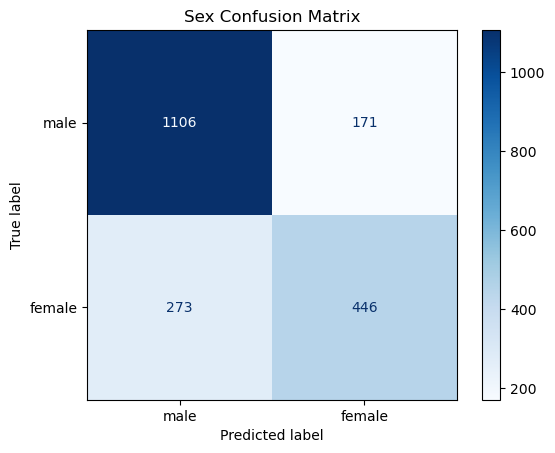

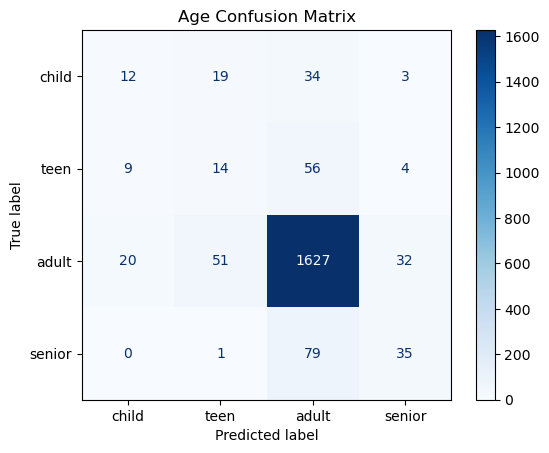

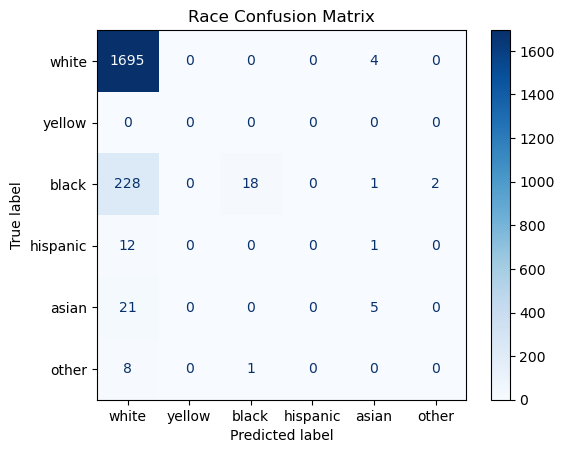

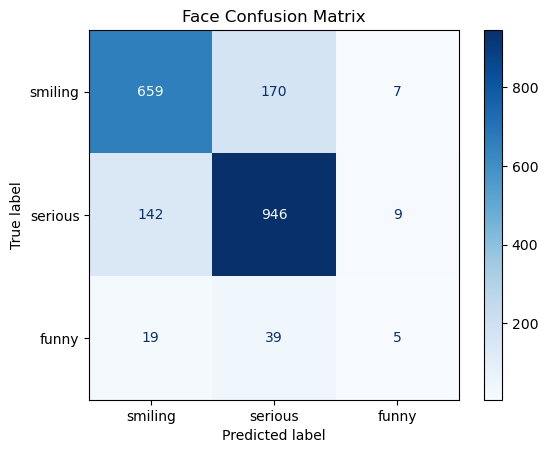

In [2]:
# 定义卷积神经网络模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 2)  # 性别
        self.fc3 = nn.Linear(256, 4)  # 年龄
        self.fc4 = nn.Linear(256, 6)  # 种族
        self.fc5 = nn.Linear(256, 3)  # 表情

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = self.relu(self.fc1(x))
        sex_output = self.fc2(x)
        age_output = self.fc3(x)
        race_output = self.fc4(x)
        face_output = self.fc5(x)
        return sex_output, age_output, race_output, face_output


# 初始化模型、损失函数和优化器
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        sex_outputs, age_outputs, race_outputs, face_outputs = model(images)
        loss = criterion(sex_outputs, labels[:, 0]) + \
               criterion(age_outputs, labels[:, 1]) + \
               criterion(race_outputs, labels[:, 2]) + \
               criterion(face_outputs, labels[:, 3])
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# 评估模型
model.eval()
total = 0

# 存储所有真实标签和预测标签
true_labels = {'sex': [], 'age': [], 'race': [], 'face': []}
pred_labels = {'sex': [], 'age': [], 'race': [], 'face': []}

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        sex_outputs, age_outputs, race_outputs, face_outputs = model(images)
        _, predicted_sex = torch.max(sex_outputs, 1)
        _, predicted_age = torch.max(age_outputs, 1)
        _, predicted_race = torch.max(race_outputs, 1)
        _, predicted_face = torch.max(face_outputs, 1)

        true_labels['sex'].extend(labels[:, 0].cpu().numpy())
        pred_labels['sex'].extend(predicted_sex.cpu().numpy())
        true_labels['age'].extend(labels[:, 1].cpu().numpy())
        pred_labels['age'].extend(predicted_age.cpu().numpy())
        true_labels['race'].extend(labels[:, 2].cpu().numpy())
        pred_labels['race'].extend(predicted_race.cpu().numpy())
        true_labels['face'].extend(labels[:, 3].cpu().numpy())
        pred_labels['face'].extend(predicted_face.cpu().numpy())

        total += labels.size(0)

# 计算并打印各个类别的准确率
def calculate_accuracy(true_labels, pred_labels, num_classes, class_names):
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(num_classes)))
    row_sums = cm.sum(axis=1)
    accuracies = np.zeros(num_classes)
    for i in range(num_classes):
        if row_sums[i] > 0:
            accuracies[i] = cm[i, i] / row_sums[i]
    print(f'Accuracy of the model on the test images for each category:')
    for i, acc in enumerate(accuracies):
        print(f'{class_names[i]} Accuracy: {100 * acc:.2f}%')

calculate_accuracy(true_labels['sex'], pred_labels['sex'], 2, ['male', 'female'])
calculate_accuracy(true_labels['age'], pred_labels['age'], 4, ['child', 'teen', 'adult', 'senior'])
calculate_accuracy(true_labels['race'], pred_labels['race'], 6, ['white', 'yellow', 'black', 'hispanic', 'asian', 'other'])
calculate_accuracy(true_labels['face'], pred_labels['face'], 3, ['smiling', 'serious', 'funny'])

# 绘制混淆矩阵
def plot_confusion_matrix(true_labels, pred_labels, num_classes, class_names, title):
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(num_classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion_matrix(true_labels['sex'], pred_labels['sex'], 2, ['male', 'female'], 'Sex Confusion Matrix')
plot_confusion_matrix(true_labels['age'], pred_labels['age'], 4, ['child', 'teen', 'adult', 'senior'], 'Age Confusion Matrix')
plot_confusion_matrix(true_labels['race'], pred_labels['race'], 6, ['white', 'yellow', 'black', 'hispanic', 'asian', 'other'], 'Race Confusion Matrix')
plot_confusion_matrix(true_labels['face'], pred_labels['face'], 3, ['smiling', 'serious', 'funny'], 'Face Confusion Matrix')


